# <font color="darkblue"> Projeto 01 - Reconhecimento de Dígitos</font>

**Objetivos**

Implementar três classificadores de dígitos contidos no dataset MNIST Adaptado, utilizando
os três modelos lineares de Aprendizagem de Máquina (AM) estudados: Perceptron, Regressão
Linear e Regressão Logística.

**Dataset MNIST adaptado**

Os arquivos train.csv e test.csv contêm imagens do dataset MNIST, em escala de cinza, dos
dígitos 0, 1, 4 e 5 escritos a mão. Cada imagem é composta por 28 linhas e 28 colunas em um
total de 784 pixels. Cada pixel possui um valor associado único, que indica seu tom de cinza.
Quanto mais alto é esse valor, mais escuro é o pixel. Os valores de cada pixel estão no intervalo
fechado [0, 255].

Os dados de entrada, (train.csv), possuem 785 colunas. A primeira coluna, chamada “label”,
é o dígito que foi desenhado pelo usuário. O resto das colunas contém os valores dos pixels da
imagem associada.

Cada coluna de pixel, nos dados de treino, é nomeada como “pixel𝑥”, onde 𝑥 é um inteiro
no intervalo [0, 783]. Para localizar este pixel na imagem, suponha que decompomos 𝑥 como
𝑥 = 𝑖 ∗ 28 + 𝑗, onde 𝑖 e 𝑗 são inteiros no intervalor [0, 27]. Então o “pixel𝑥” está localizado nalinha 𝑖 e coluna 𝑗 de uma matriz 28𝑥28 (indexada por zero). Por exemplo, “pixel31” indica o valor do pixel que está na quarta coluna, da esquerda pra direita, e na segunda linha.

Os dados de teste, (test.csv), possuem o mesmo formato dos dados de treinamento.

# <font color="darkblue"> Solução </font>

**Importação do dataset**

In [1]:
import numpy as np

data_path = "dataset_digits/"
train = np.genfromtxt(data_path + "train.csv", delimiter=";")
test = np.genfromtxt(data_path + "test.csv", delimiter=";")

# Rm first line of labels
train = train[1:]
test = test[1:]

0
28


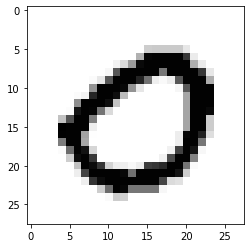

In [2]:
import matplotlib.pyplot as plt
        
dim = 28

def get_images_and_labels(data):
    """
    Retorna as imagens como matrizes 28x28 e os labels correspondentes
    """
    delta = 1 # delta para "pular" o label da imagem
    X = np.empty(shape=(len(data), dim, dim))
    y = np.empty(len(data), dtype=int)
    for i, img in enumerate(data):
        # x = 28i + j
        X[i] = [[img[delta + 28*i + j] for i in range(dim)] for j in range(dim)]
        y[i] = int(img[0])

    return X, y

train_X, train_y = get_images_and_labels(train)
test_X, test_y = get_images_and_labels(test)

print(train_y[0])
print(train_X.shape[1])
plt.imshow(train_X[0], cmap="Greys")
plt.show()

**Redução da dimensão da amostra**

Para trabalharmos com modelos de AM que possuem muito pouco grau de liberdade
para a construção de sua função hipótese, devemos diminuir a complexidade dos dados de
entrada através da redução do número de parâmetros 𝑝 das amostras de treinamento.

Como já foi dito na descrição do dataset, cada instância é composta por 𝑝 = 784
parâmetros de entrada, sendo um parâmetro por pixel. Logo, há a necessidade de reduzir a
quantidade de parâmetros total, a fim de atingir bons resultados na classificação das de tais
imagens usando-se modelos de AM mais simples. Uma forma de reduzir consideravelmente
o vetor de características é sintetizar os dados das imagens em apenas duas informações de
entrada (𝑝 = 2) que são muito importantes na identificação de um dígito numérico: a
intensidade e a simetria da imagem.

**Cálculo de intensidade e simetria das imagens**


Intensidade             |  Simetria Vertical
:-------------------------:|:-------------------------:
<img title="" alt="" width="350" src="I.png">  |  <img title="" alt="" width="350" src="Sv.png">

<!-- <p float="left">
<img title="" alt="" width="350" src="I.png">
<img title="" alt="" width="350" src="Sv.png">
</p> -->

In [3]:
def comp_intensity(x):
    """
    Calcula a intensidade (I) de acordo com a fórmula acima.
    """
    return np.sum(x) / 255.0
            
def comp_vsymmetry(x):
    """
    Calcula a simetria vertical (Sv) de acordo com a fórmula acima.
    """
    Sv = 0.0
    for i in range(dim):
        for j in range(int(dim / 2)):
            Sv += abs(x[i, j] - x[i, dim - 1 - j])
    return Sv / 255.0

def comp_hsymmetry(x):
    """
    Calcula a simetria horizontal de forma análoga ao cálculo para a simetria vertical.
    """
    Sh = 0.0
    for i in range(int(dim / 2)):
        for j in range(dim):
            Sh += abs(x[i, j] - x[dim - 1 - i, j])
    return Sh / 255.0

def comp_symmetry(x):
    return comp_vsymmetry(x) + comp_hsymmetry(x)

**Construção de novos arquivos**

Nesta atividade, deve-se construir novos arquivos de treino e teste a serem chamados
de train_redu.csv e test_redu.csv. Esses arquivos conterão as seguintes colunas: label,
intensidade e simetria. 

In [4]:
def normalize(data, j):
    """
    Normaliza os dados da coluna j entre 0 e 1.
    """
    a = min(data, key=lambda x: x[j])[j]
    b = max(data, key=lambda x: x[j])[j]
    d = b - a
    for i, x in enumerate(data):
        data[i][j] = (data[i][j] - a) / d

def comp_redu(data, labels):
    """
    Computa a versão reduzida dos dados, transformando o label + 784 parâmetros de intensidade de pixel em (label, intensidade, simetria).
    Os dados retornados estão normalizados entre 0 e 1.
    """
    new_data = np.empty(shape=(len(data), 3))
    for i, x in enumerate(data):
        new_data[i] = [labels[i], comp_intensity(x), comp_symmetry(x)]
    normalize(new_data, 1)
    normalize(new_data, 2)
    return new_data

train_redu = comp_redu(train_X, train_y)
test_redu = comp_redu(test_X, test_y)

**Classificação dos dígitos 1 x 5**
    
Como no modelo Perceptron a classificação é binária, uma alternativa para realizar
classificações multiclasse de dígitos é construir, inicialmente, uma solução que classifique
apenas dois valores de dígitos: 1 e 5, por exemplo. Para isto, deve-se:

- Realizar um filtro nos dados dos arquivos train_redu.csv e test_redu.csv, deixando
apenas as imagens com valores 1 ou 5 na coluna label, construindo as instâncias
train1x5 e test1x5;
- Plotar os dados de train1x5 em um gráfico de duas dimensões (intensidade X
simetria) como ilustrado na Figura 4. Dados com 𝑙𝑎𝑏𝑒𝑙 = 1 plotar de azul e dados
com 𝑙𝑎𝑏𝑒𝑙 = 5 plotar de vermelho;

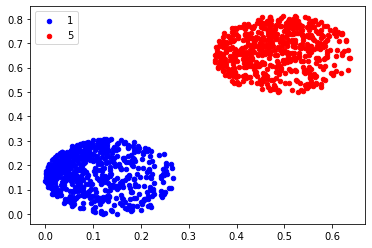

In [5]:
def filter(data, digits):
    """
    Filtra "data" de acordo com "digits".
    """
    f_data = np.empty(shape=(0,3))
    for i, x in enumerate(data):
        for _, d in enumerate(digits):
            if x[0] == d:
                f_data = np.append(f_data, [x], axis=0)
                break
    return f_data

def plot_data(data, digits):
    """
    Plota os dados cujos labels são iguais a algum dos valores em "digits".
    """
    N = data.shape[0]
    colors = ['blue', 'red', 'green', 'orange']
    l = []
    for c, d in enumerate(digits):
        # cor dos pontos com labels digits[0]
        x = [data[i][1] for i in range(N) if data[i][0] == d]
        y = [data[i][2] for i in range(N) if data[i][0] == d]
        plt.scatter(x, y, color=colors[c], marker='o', s=20)
        l.append(str(d))
    plt.legend(l, loc=2)
    # plt.show()

digits = [1, 5]
train1x5 = filter(train_redu, digits)
test1x5 = filter(test_redu, digits)

plot_data(train1x5, digits)
# plt.show()
# plot_data(test1x5, digits)

- Treinar os três classificadores com os dados de train1x5. Construir o vetor 𝑋 =
{(𝑖𝑛𝑡𝑒𝑛𝑠𝑖𝑑𝑎𝑑𝑒, 𝑠𝑖𝑚𝑒𝑡𝑟𝑖𝑎)} para toda imagem de train1x5. Atribuir o valor alvo
𝑦 = +1 para a imagem com valor 𝑙𝑎𝑏𝑒𝑙 = 1 e 𝑦 = −1 para 𝑙𝑎𝑏𝑒𝑙 = 5;

In [6]:
import classifiers as cls

def get_Xy(data, digits):
    """
    Retorna X = {(1, intensidade, simetria)} e y, com labels 1 para digits[0] e -1 para os demais.
    """
    N = data.shape[0]
    X = np.array(data[:,1:3])
    X = np.insert(X, 0, 1, axis=1)
    y = np.where(data[:,0] == digits[0], 1, -1)
    return X, y

X, y = get_Xy(train1x5, digits)

pla = cls.PocketLearningAlgorithm()
pla.fit(X, y)
print(pla.get_w())

lir = cls.LinearRegression()
lir.fit(X, y)
print(lir.get_w())

lor = cls.LogisticRegression()
lor.fit(X, y)
print(lor.get_w())

[ 1.         -1.38233085 -1.39531523]
[ 1.54070954 -2.15454424 -2.17771687]
[ 2.98570863 -3.75104723 -4.78801729]


- Construir o vetor 𝑋 = {(𝑖𝑛𝑡𝑒𝑛𝑠𝑖𝑑𝑎𝑑𝑒, 𝑠𝑖𝑚𝑒𝑡𝑟𝑖𝑎)} para toda imagem de test1x5.
Atribuir o valor alvo 𝑦 = 𝑙𝑎𝑏𝑒𝑙 para cada imagem de test1x5;
- Testar os três classificadores com os dados de test1x5;
- Plotar a reta de cada classificador sobre os dados;

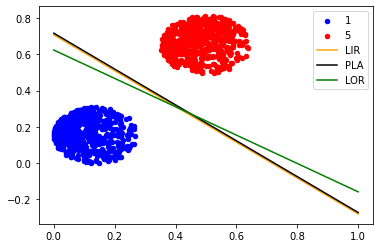

In [7]:
def plot_f(cls, color):
    x_p = [0, 1]
    y_p = [cls.get_y(x_p[0]), cls.get_y(x_p[1])]
    plt.plot(x_p, y_p, c=color)
    # plt.legend()

X, y = get_Xy(test1x5, digits)
# neste caso, queremos os labels mesmo
# y = [int(d[0]) for d in test1x5 if d[0] == digits[0] or d[0] == digits[1]]

lir_y = lir.predict(X)
pla_y = pla.predict(X)
lor_y = lor.predict(X)

plot_data(train1x5, digits)

plot_f(lir, 'orange')
plot_f(pla, 'black')
plot_f(lor, 'green')

plt.legend(['1', '5', 'LIR', 'PLA', 'LOR'])

- Gerar a matriz de confusão e os relatórios de eficácia de classificação de cada
classificador.

In [8]:
from sklearn import metrics

def comp_reports(y_true, y_pred):
    print('Matriz de confusão:', metrics.confusion_matrix(y_true, y_pred))
    print('Acurácia:', metrics.accuracy_score(y_true, y_pred))
    print('Precisão:', metrics.precision_score(y_true, y_pred, average=None))
    print('F1 score:', metrics.f1_score(y_true, y_pred, average=None))

print("---Regressão linear")
comp_reports(lir_y, y)
print("\n---Pocket learning algorithm")
comp_reports(pla_y, y)
print("\n---Regressão logística")
comp_reports(lor_y, y)

---Regressão linear
Matriz de confusão: [[291   0]
 [  0 292]]
Acurácia: 1.0
Precisão: [1. 1.]
F1 score: [1. 1.]

---Pocket learning algorithm
Matriz de confusão: [[291   0]
 [  0 292]]
Acurácia: 1.0
Precisão: [1. 1.]
F1 score: [1. 1.]

---Regressão logística
Matriz de confusão: [[291   0]
 [  0 292]]
Acurácia: 1.0
Precisão: [1. 1.]
F1 score: [1. 1.]


**Classificador de dígitos completo**

Para construir um classificador para os quatro dígitos contidos na base, deve-se
implementar uma estratégia conhecida como “um contra todos”. Nessa estratégia,
inicialmente, escolhe-se o dígito 0 para ser a classe 𝑦 = +1 e todas os outros dígitos (1, 4 e 5), temporariamente, definidos como a classe 𝑦 = −1. Essa transformação está ilustrada na
Figura 5.

A função hipótese 𝑓0 é inferida pelos novos dados de treino e usada para classificar os
dados de teste. Se 𝑓0 classificar o novo dado como da classe +1, então podemos afirmar
que a imagem associada é do dígito 0. Se o dado for classificado como −1, nada pode ser
afirmado. O próximo passo é criar uma nova instância de treino, eliminando as instâncias
com label=0, e construindo uma classificação binária do dígito 1 contra todos.
Ao final serão construídas três funções hipótese que juntas irão realizar a classificação
multiclasse dos quatro dígitos. Seja 𝑥 a imagem teste a ser classificada, classifique 𝑥 com o
seguinte algoritmo:

<img title="" alt="" width="350" src="classificador.png">

In [9]:
import time
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# Classe genérica
class Classifier:
    def __init__(self, classifier):
        self.cls = classifier
        self.f = []
        self.digits = [0, 1, 4, 5]

    def fit(self, data, en_plt=True):
        d = len(self.digits)
        if en_plt:
            plot_data(data, self.digits[0:d])
        colors = ['black', 'gray', 'silver']
        for i, _ in enumerate(self.digits[0:d-1]):
            train = filter(data, self.digits[i:d])
            X, y = get_Xy(train, self.digits[i:d])
            f = self.cls()
            f.fit(X, y)
            if en_plt:
                plot_f(f, colors[i])
            self.f.append(f)
            
    def predict(self, data):
        """
        Faz a predição dos dados de acordo com o algoritmo acima.
        """
        X, _ = get_Xy(data, self.digits)
        d = len(self.digits)
        p = []
        for x in X:
            for i, _ in enumerate(self.digits[0:d - 1]):
                if self.f[i].predict([x]) == [1]:
                    p.append(self.digits[i])
                    break
                elif i == d - 2:
                    p.append(self.digits[d - 1])
        return p

    def comp_reports(self, test_redu):
        y_true = [int(x) for x in test_redu[:,0]]
        y_pred = self.predict(test_redu)
        cm = metrics.confusion_matrix(y_true, y_pred)
        print('Matriz de confusão:\n', cm)
        print('Acurácia:', metrics.accuracy_score(y_true, y_pred))
        print('Precisão:', metrics.precision_score(y_true, y_pred, average=None))
        print('F1 score:', metrics.f1_score(y_true, y_pred, average=None))

        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=self.digits)
        disp.plot()
            
    def set_digits(self, new_digits):
        self.digits = new_digits

    def get_w(self, i):
        return self.f[i].get_w()

    def set_w_iniciais(self, w):
        self.w = w

    def get_acuracia(self):
        return self.acuracia

**Comparação entre os classificadores**

Para comparar os três classificadores, implemente a estratégia “um contra todos” para
cada um dos algoritmos de classificação, construa:
1. A matriz de confusão e o relatório de eficácia de classificação contendo: acurácia,
precisão, recall e f1 score;
2. Para cada classificador plotar as três retas construídas sobre os dados dos 4 dígitos.

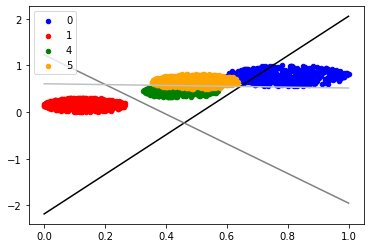

Matriz de confusão:
 [[176   0   0  42]
 [  0 292   0   0]
 [  0   0 306   8]
 [  0   0  24 267]]
Acurácia: 0.9336322869955157
Precisão: [1.         1.         0.92727273 0.84227129]
F1 score: [0.89340102 1.         0.95031056 0.87828947]


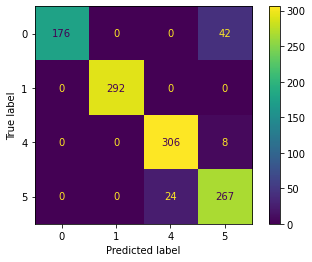

In [10]:
cls_lir = Classifier(cls.LinearRegression)
cls_lir.fit(train_redu)

plt.show()
cls_lir.comp_reports(test_redu)

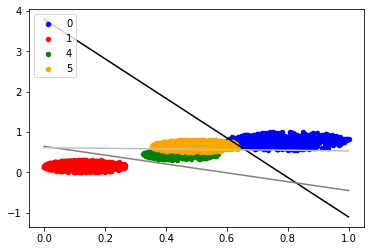

Matriz de confusão:
 [[217   0   0   1]
 [  0 292   0   0]
 [  0   0 312   2]
 [  1   0  31 259]]
Acurácia: 0.968609865470852
Precisão: [0.99541284 1.         0.90962099 0.98854962]
F1 score: [0.99541284 1.         0.94977169 0.93670886]


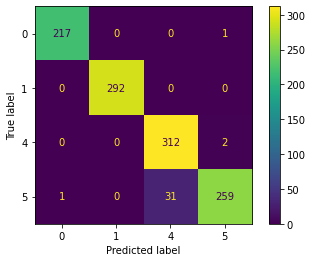

In [11]:
cls_pla = Classifier(cls.PocketLearningAlgorithm)
cls_pla.fit(train_redu)

plt.show()
cls_pla.comp_reports(test_redu)

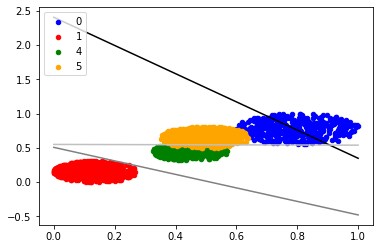

Matriz de confusão:
 [[125   0   0  93]
 [  0 292   0   0]
 [  0   0 285  29]
 [  0   0  13 278]]
Acurácia: 0.8789237668161435
Precisão: [1.         1.         0.95637584 0.695     ]
F1 score: [0.72886297 1.         0.93137255 0.80463097]


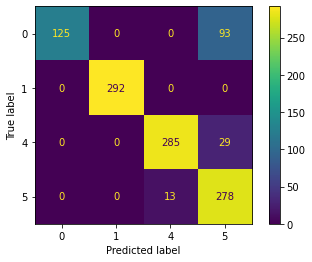

In [12]:
cls_lor = Classifier(cls.LogisticRegression)
cls_lor.fit(train_redu)

plt.show()
cls_lor.comp_reports(test_redu)

**Implementações avançadas**

- Implementar a estratégia de “um contra todos” definindo a ordem de teste dos dígitos
que leve à melhor acurácia global. Ou seja, a ordem proposta anteriormente pode ser
alterada para uma ordem arbitrária que produza uma melhor acurácia de classificação.

In [13]:
from itertools import permutations

def comp_melhor_seq(cls):
    digits = [0, 1, 4, 5]
    best_ac = 0.0
    best_seq = digits
    # nb_perms = 24
    # i = 0
    for p in permutations(digits):
        # print(f'Concluído: {round(i / nb_perms, 1)}\r')
        cls.set_digits(p)
        cls.fit(train_redu, False)
        plt.show()
        pred = cls.predict(test_redu)
        ac = metrics.accuracy_score(pred, test_y)
        # print('Acurácia:', ac)
        if ac > best_ac:
            best_ac = ac
            best_seq = p
    
    return best_seq, best_ac

r = comp_melhor_seq(cls_lir)
print('Melhor sequência modelo regressão linear:', r[0])
print('Acurácia:', r[1])

r = comp_melhor_seq(cls_pla)
print('Melhor sequência modelo pocket learning algorithm:', r[0])
print('Acurácia:', r[1])

r = comp_melhor_seq(cls_lor)
print('Melhor sequência modelo regressão logística:', r[0])
print('Acurácia:', r[1])

Melhor sequência modelo regressão linear: (0, 1, 4, 5)
Acurácia: 0.9336322869955157
Melhor sequência modelo pocket learning algorithm: (0, 1, 4, 5)
Acurácia: 0.968609865470852
Melhor sequência modelo regressão logística: (0, 1, 4, 5)
Acurácia: 0.8789237668161435
